# Assignment 4

In this assignment, you will be using univariate LSTM models on time series.

* [1. Introduction](#h1)  

* [2. Univariate time series: LSTM](#h2)  

 


In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/DS5660/hw4')

Mounted at /content/drive


## 1. Introduction <a name="h1"></a>

In this homework, we will model temporal trends on sales price of items from a grocery store. There are 50 items from 10 locations. We will first look at univariate temporal trends, which means that only one item from one location is picked. Then we will run a univariate LSTM model to predict the temporal trend.

In [2]:
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.5MB 10.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
import math

color = sns.color_palette()
sns.set_style('darkgrid')

# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Download data from [GitHub](https://github.com/yuankaihuo/DL_course_hw/tree/master/Homework%202/data) and save them on your drive

In [4]:
# load data
train_data = pd.read_csv("data/train.csv",parse_dates=['date'])

# focus on 1 store and 1 item
train_data = train_data[(train_data['store']==1) & (train_data['item']==1)] # 1460 by 4

train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.dayofyear
train_data['weekday'] = train_data['date'].dt.weekday

# make training and validation sets 
days = train_data.shape[0]
train_df = train_data.iloc[:(days - 90),:] # 3 years and 9 months
validate_df = train_data.iloc[-90:,:] # last 90 days

print("The training set has " + str(train_df.shape[0]) +" rows, and " + str(train_df.shape[1]) + " columns.")
print("The validation set has " + str(validate_df.shape[0]) +" rows, and " + str(validate_df.shape[1]) + " columns.")

The training set has 1370 rows, and 8 columns.
The validation set has 90 rows, and 8 columns.


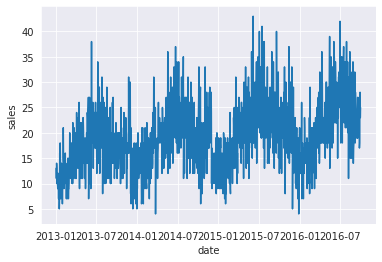

In [5]:
# full temporal trend
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)
plt.show()

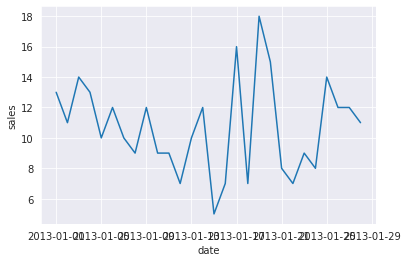

In [6]:
# temporal trend of first 28 days
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])
plt.show()

### Seasonality decomposition

<Figure size 432x288 with 0 Axes>

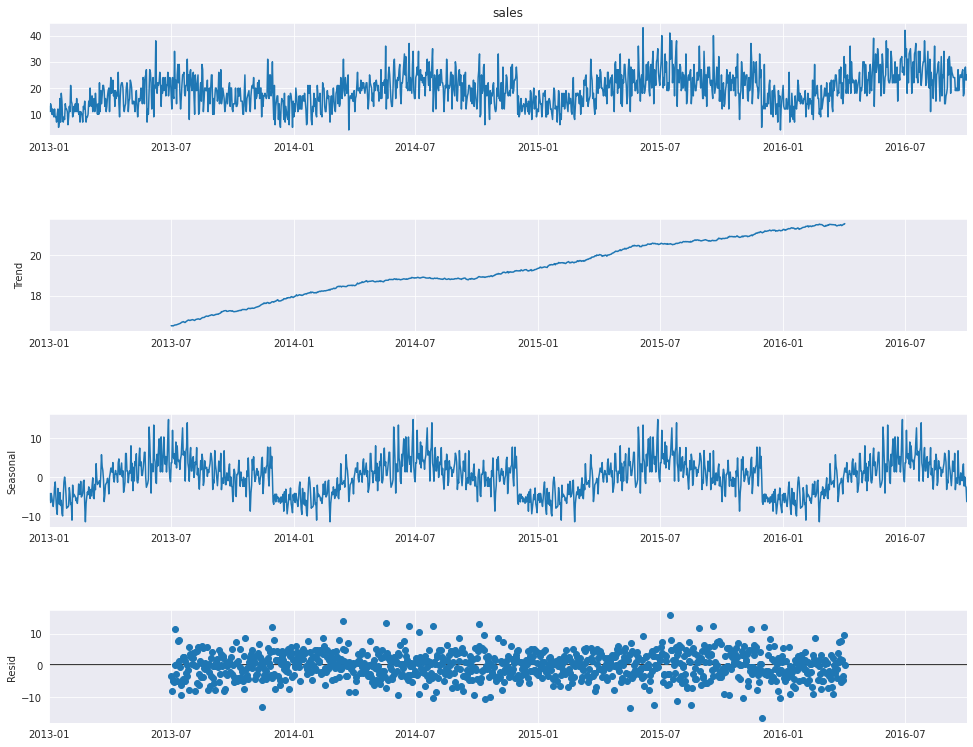

In [7]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
validate_df = validate_df.set_index('date')
validate_df['sales'] = validate_df['sales'].astype(float)

result = seasonal_decompose(train_df['sales'], model='additive',period=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()


## 2. Univariate time series: LSTM <a name="h2"></a>

Again, we use the item 1 from store 1 as an example to illustrate how LSTM works with one dimensional input.

In [8]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


The training data set has 3 years and 9 months data, and the validation data set has 3 months data.  

In [9]:
# reading the input data
train_df = pd.read_csv('data/train.csv',parse_dates=['date'])
train_df = train_df[(train_df['store'] == 1) & (train_df['item'] == 1)]

all_train_data = train_df['sales'].values.astype(float)

train_data = all_train_data[:-90] # 3 years and 9 months
test_data = all_train_data[-90:] # last 90 days


First, let's scale the data

In [10]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = scaler.fit_transform(test_data .reshape(-1, 1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

Set the training window to be 7 days. You can tune this parameter for better performance.  

In [11]:
# moving window
train_window = 3

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window)


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=150, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()

def model_train(epochs = 30):
    
    test_loss_min = 100
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for i in range(1,epochs+1):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            for seq, labels in test_inout_seq:
                y_test_pred = model(seq)
                test_loss = loss_function(y_test_pred.float(), labels)
        
        if test_loss < test_loss_min:
            # Save model
            torch.save(model.state_dict(), 'best_model.pt')
            test_loss_min = test_loss

        if i%10 == 0:
            print(f'Epoch {i} train loss: {single_loss.item():.4f} test loss: {test_loss.item():.4f}')

Train the model 

In [ ]:
model_train(epochs=200)

Epoch 10 train loss: 0.0010 test loss: 0.3937
Epoch 20 train loss: 0.0024 test loss: 0.6190
Epoch 30 train loss: 0.0032 test loss: 0.5089
Epoch 40 train loss: 0.0037 test loss: 0.4299
Epoch 50 train loss: 0.0040 test loss: 0.3527
Epoch 60 train loss: 0.0043 test loss: 0.3055
Epoch 70 train loss: 0.0045 test loss: 0.2824
Epoch 80 train loss: 0.0045 test loss: 0.2669
Epoch 90 train loss: 0.0047 test loss: 0.2583
Epoch 100 train loss: 0.0047 test loss: 0.2574
Epoch 110 train loss: 0.0046 test loss: 0.2610
Epoch 120 train loss: 0.0044 test loss: 0.2654
Epoch 130 train loss: 0.0042 test loss: 0.2700
Epoch 140 train loss: 0.0041 test loss: 0.2806
Epoch 150 train loss: 0.0041 test loss: 0.2947
Epoch 160 train loss: 0.0041 test loss: 0.3105
Epoch 170 train loss: 0.0041 test loss: 0.3282
Epoch 180 train loss: 0.0042 test loss: 0.3478
Epoch 190 train loss: 0.0043 test loss: 0.3689
Epoch 200 train loss: 0.0044 test loss: 0.3911


Prediction in the validation set (next 90 days)

In [12]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [13]:

fut_pred = 90

test_inputs = train_data_normalized[-train_window:].tolist()
# print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))


LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [15]:
test_data

array([26., 20., 28., 17., 22., 19., 24., 29., 18., 18., 16., 16., 32.,
       32., 26., 20., 21., 20., 30., 25., 26., 21., 16., 13., 16., 25.,
       18., 23., 33., 24., 22., 23., 23., 22., 29., 18., 17., 19., 22.,
       18., 26., 26., 36., 17., 22., 20., 19., 21., 36., 22., 14., 18.,
       20., 18., 26., 20., 20., 22., 27., 19., 13., 11., 19., 24., 13.,
       10., 17., 15.,  7., 12., 20., 12., 23., 12., 10., 15., 19., 22.,
       17., 18., 12., 20., 21., 13., 20., 16., 10., 16., 21., 24.])

Plot prediction calibration

Text(0, 0.5, 'Sales')

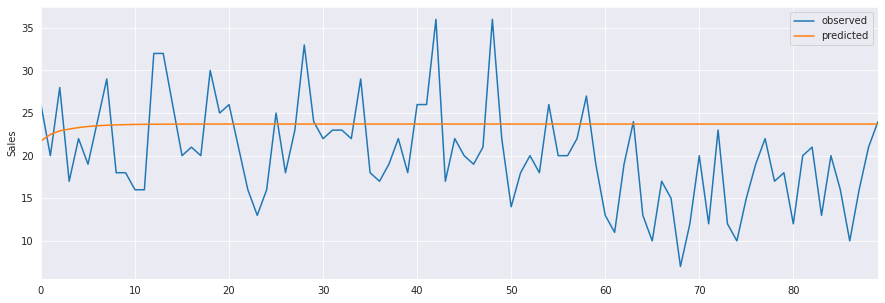

In [14]:
# plot calibration
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test_data,label="observed")
plt.plot(actual_predictions,label="predicted")
plt.legend()
plt.show()


Calculate prediction RMSE

In [ ]:
# rmse
math.sqrt(mean_squared_error(test_data,actual_predictions))

6.7835366346672785

In [ ]:
actual_predictions= pd.DataFrame(
        actual_predictions,
        columns=['model1'])
actual_predictions.to_csv("actual_predictions.csv",index=False)

## modification 1 change the train——window <a name="h2"></a>

The "window" size controls how many consecutive time series are put together. Change train window from 7 to 3 since the weekdays and weekend will be different so I think 7 is better than 3. 

The RMSE results goes from 6.5 to 6.1. 

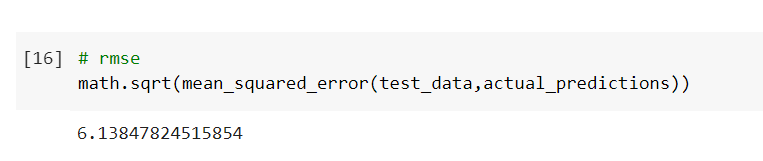


## modification 2 change the hidden_layer_size <a name="h2"></a>

Change hidden_layer_size from 100 to 200. An overfiting condition occurs in excess of 150. The larger hidden size is, the higher the complexity of the model may be and the phenomenon of overfitting may occur. However, the model effect can be improved by increasing hidden size to a certain extent 

The RMSE results goes from 6.5 to 6.9. 

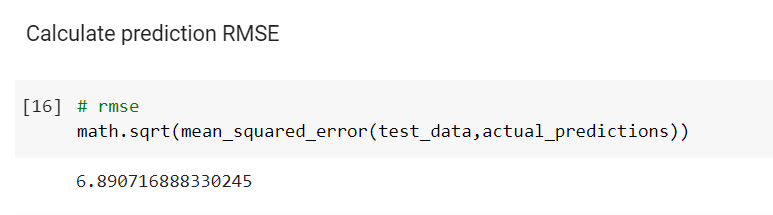

## modification 3 change the learning rate <a name="h2"></a>

I think the current data size is too small for the complex model like LSTM, so I change the learning rate from 0.001 to 0.0001 to see what will happened. The results will be show in my model3

## 3 models for ensemble <a name="h2"></a>

## model1 RMSE 6.5 

original model

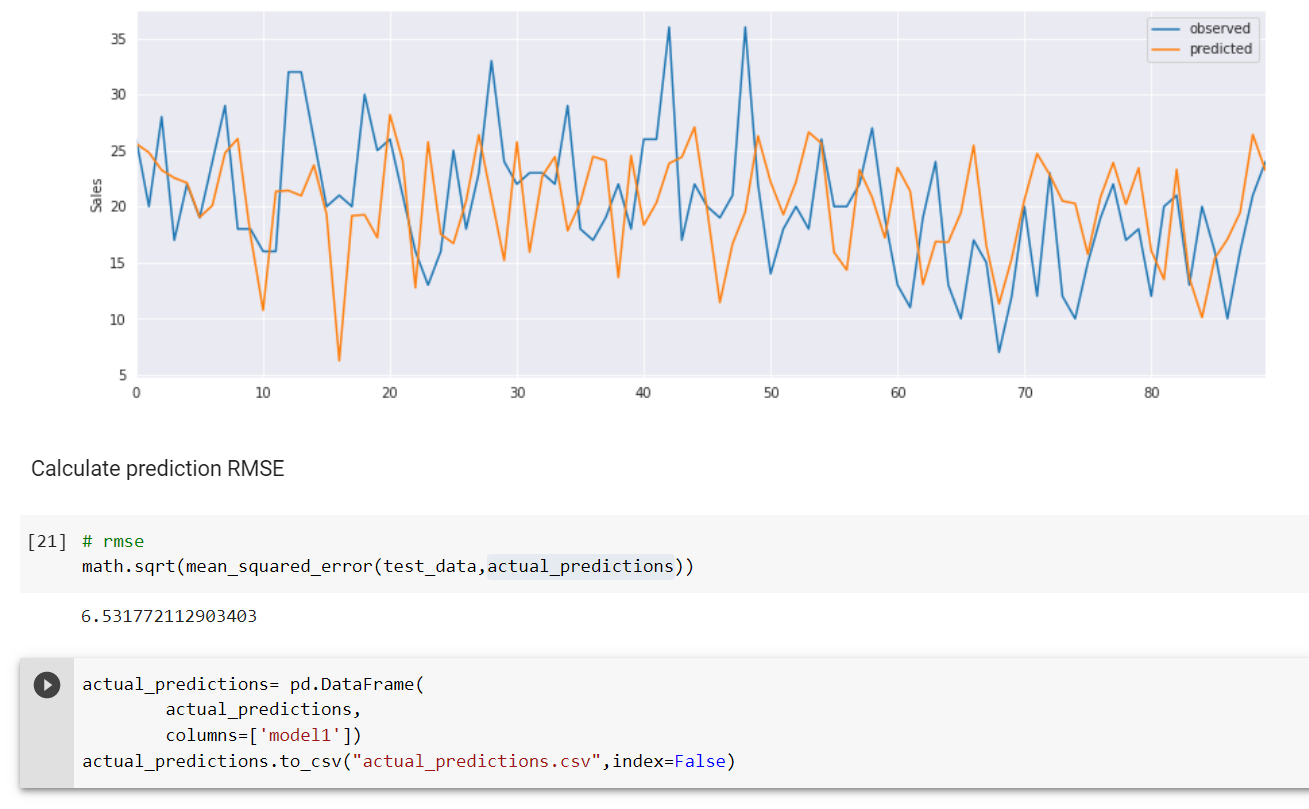

## model2 RMSE 5.9

window 3； hidden_layer_size =150

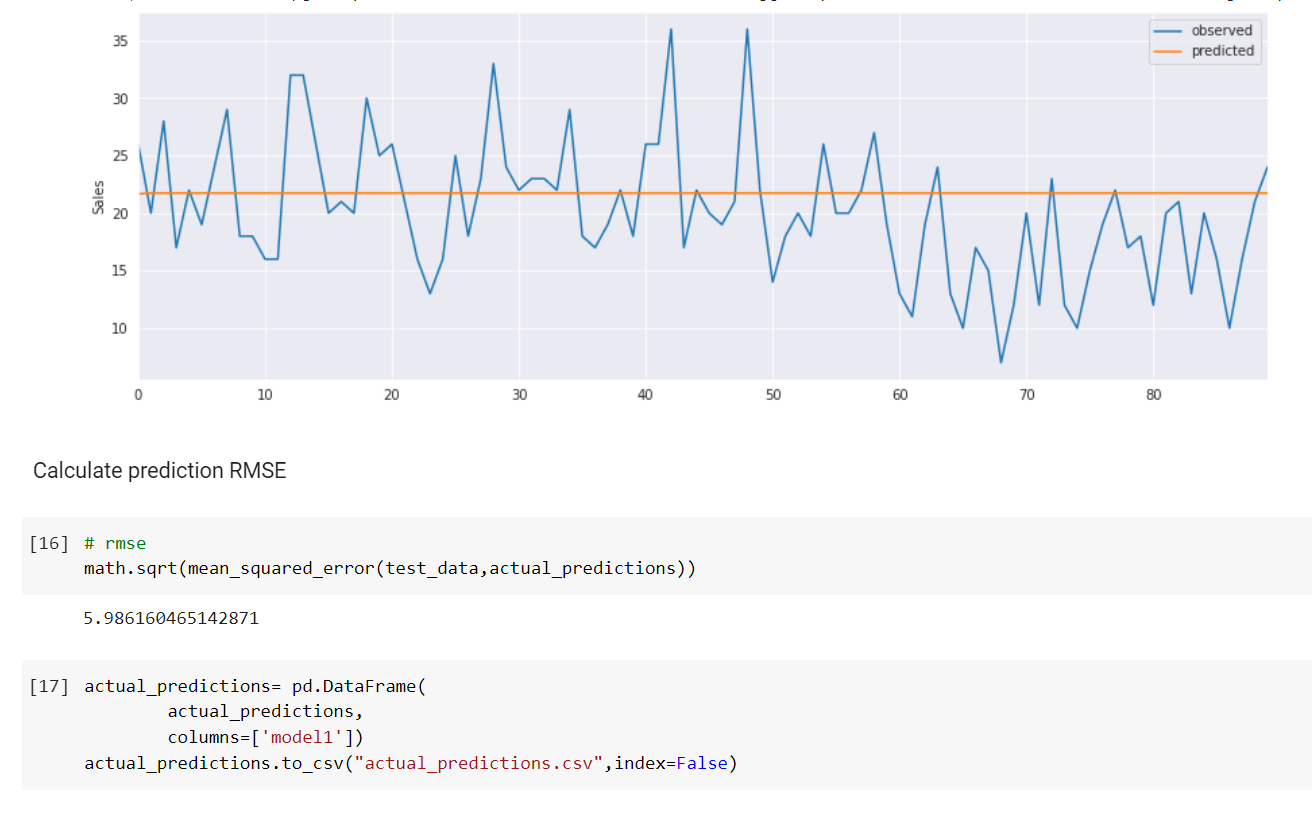

## model3 RMSE 6.8

window 3； hidden_layer_size =150； lr=0.0001

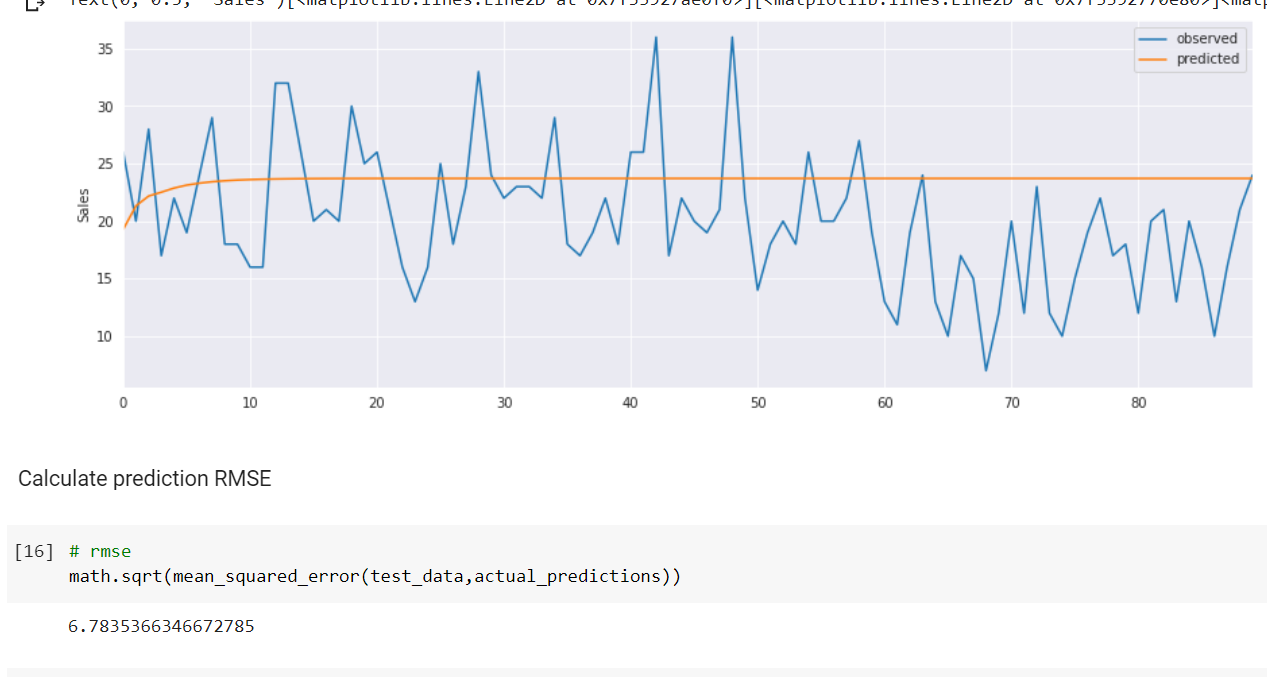




## ensemble results RMSE 5.9 <a name="h2"></a>

In [ ]:
ensemble = pd.read_csv("ensemble.csv")

In [ ]:
print(ensemble)

    day     model1     model2     model3   ensemble
0     1  25.597820  21.667054  19.288876  22.184583
1     2  24.816194  21.744323  21.325189  22.628568
2     3  23.250871  21.744833  22.179799  22.391834
3     4  22.551979  21.742667  22.514943  22.269863
4     5  22.111355  21.742244  22.874846  22.242815
..  ...        ...        ...        ...        ...
85   86  15.375063  21.742171  23.714163  20.277132
86   87  17.086546  21.742171  23.714163  20.847627
87   88  19.457486  21.742171  23.714163  21.637940
88   89  26.425337  21.742171  23.714163  23.960557
89   90  23.222739  21.742171  23.714163  22.893024

[90 rows x 5 columns]


In [ ]:
ensemble_col = ensemble.loc[:,'ensemble']
ensemble_col=ensemble_col.values

# rmse
math.sqrt(mean_squared_error(test_data,ensemble_col))

5.90310189704966

## modification plan <a name="h2"></a>

It is better to change the model find one instead of LSTM